## Plots for PASP paper - comparing literature observations to simulation

In [1]:
import numpy as np
import eagle_constants_and_units as c
import cosmo_utils as csu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from astropy import constants as const
from astropy import units as u

from matplotlib.patches import ConnectionPatch

import os
import get_halpha_SB

%matplotlib inline

%run 'load_data.ipynb'
%run 'add_noise.ipynb'
%run 'extract_FOV.ipynb'
%run 'mask_galaxies.ipynb'

In [2]:
machine='chinook'

### STUFF WE MUST HAVE:
slicewidth = 20.        # initial value
resolution = None      # initial value   # arcsec/pixel
distance   = '100Mpc'  # initial value
data_FOV =None  # from extract_FOV
xystarts =None  # from extract_FOV
size     =None  # from extract_FOV

data_tuple = loaddata(machine=machine, distance=distance, slicewidth=slicewidth)  ### I want this to set the resolution too


Resolution is None, finding minimum resolution of the similuation...
The resolution of the raw simulation at 100Mpc is 6.40094057981256.
Loading data of slicewidth 20 (after rounding), number of slices is 4
./intermediatedata/data_100Mpc_6arcsec_20slwd.npz exists, loading now...
./intermediatedata/data_100Mpc_6arcsec_20slwd.npz was not saved as a tuple since too large, returning as tuple with 32000,1,6.40094057981256 appended.


In [18]:
data = data_tuple[0]
resolution = data_tuple[3]
xsize = data.shape[0]; ysize = data.shape[1]
boxsize = 0.2
print (data.shape)
print (resolution)

(32000, 32000)
6.40094057981256


In [4]:
FOV1_50, xystarts1_50, size1_50    = extractFOV(data_tuple,  resolution, '50Mpc', x_center = 50.5, y_center = 13.5)
FOV1_100, xystarts1_100, size1_100 = extractFOV(data_tuple,  resolution, '100Mpc', x_center = 50.5, y_center = 13.5)
FOV1_200, xystarts1_200, size1_200 = extractFOV(data_tuple,  resolution, '200Mpc', x_center = 50.5, y_center = 13.5)
FOV1_500, xystarts1_500, size1_500 = extractFOV(data_tuple,  resolution, '500Mpc', x_center = 50.5, y_center = 13.5)
FOV1_1000, xystarts1_1000, size1_1000 = extractFOV(data_tuple,  resolution, '980Mpc', x_center = 50.5, y_center = 17.5)
FOV1_1600, xystarts1_1600, size1_1600 = extractFOV(data_tuple,  resolution, '1600Mpc', x_center = 50.5, y_center = 31.5)
print (FOV1_1000.shape)
print (xystarts1_1000)

(16392, 10928)
[24.887500000000003, 0.42500000000000004]


In [6]:
verbose = True

import eagleSqlTools_kyleoman as sql
  
mySim = ('RefL0100N1504',100.)
con   = sql.connect("dlokhorst",password="mxdPB54Y")  

myQuery  =  " SELECT \
                SH.StarFormationRate as SFR, \
                SH.CentreOfPotential_x as sh_x , \
                SH.CentreOfPotential_y as sh_y , \
                SH.CentreOfPotential_z as sh_z , \
                SH.SubGroupNumber, \
                SH.HalfMassProjRad_Gas, \
                SH.HalfMassProjRad_Star, \
                FOF.Group_R_Crit200 as R200, \
                FOF.Group_R_TopHat200 as RTopHat, \
                FOF.Group_M_Crit200 as M200, \
                FOF.Group_M_TopHat200 as MTopHat, \
                FOF.GroupCentreOfPotential_x as fof_x , \
                FOF.GroupCentreOfPotential_y as fof_y , \
                FOF.GroupCentreOfPotential_z as fof_z , \
                SH.MassType_Star as mstar , \
                FOF.GroupMass as fof_mass , \
                square(SH.CentreOfPotential_x -FOF.GroupCentreOfPotential_x) + \
                    square(SH.CentreOfPotential_y -FOF.GroupCentreOfPotential_y) + \
                    square(SH.CentreOfPotential_z -FOF.GroupCentreOfPotential_z) as dist \
            FROM \
                RefL0100N1504_Subhalo as SH, \
                RefL0100N1504_FOF as FOF \
            WHERE \
                SH.MassType_Star > 1.0e9\
                and SH.SnapNum = 28 \
                and SH.CentreOfPotential_z >= 10 \
                and SH.CentreOfPotential_z <= 15 \
                and FOF.SnapNum = SH.SnapNum \
                and FOF.GroupID = SH.GroupID"

## NOTE:  I had to shorten the query down to the following because for some reason I was getting a time-out error
## from the SQL which appears to happen because the query was too long (!!!???).  Getting rid of some lines works though....
## So weird.

myQuery = "SELECT \
            SH.StarFormationRate as SFR, \
            SH.CentreOfPotential_x as sh_x,\
            SH.CentreOfPotential_y as sh_y,\
            SH.CentreOfPotential_z as sh_z,\
            SH.MassType_Star as mstar,\
            FOF.Group_R_Crit200 as R200,\
            FOF.Group_M_Crit200 as M200, \
            FOF.Group_R_TopHat200 as RTopHat, \
            FOF.Group_M_TopHat200 as MTopHat, \
            SH.HalfMassProjRad_Star, \
            SH.HalfMassProjRad_Gas, \
            FOF.GroupMass as fof_mass\
        FROM   \
            RefL0100N1504_Subhalo as SH, \
            RefL0100N1504_FOF as FOF  \
        WHERE   \
            SH.MassType_Star > 1.0e9     \
            and SH.SnapNum = 28 \
            and SH.CentreOfPotential_z >= 10 \
            and SH.CentreOfPotential_z <= 15 \
            and FOF.SnapNum = SH.SnapNum \
            and FOF.GroupID = SH.GroupID"

if verbose:
    print (myQuery)
    
myData = sql.execute_query(con,myQuery)

#sfr  = myData['SFR'][:]
# Location of the galaxy
xgal = myData['sh_x'][:]                  # cMpc
ygal = myData['sh_y'][:]                  # cMpc
zgal = myData['sh_z'][:]                  # cMpc
# Stellar Mass of the galaxy
mgal = myData['mstar'][:]                 # M_solar
# Effective Radii
rhgas = myData['HalfMassProjRad_Gas'][:]  # pkpc
rhstar= myData['HalfMassProjRad_Star'][:] # pkpc
# Virial Radii and Halo Masses
R200 = myData['R200'][:]                  # pkpc
M200 = myData['M200'][:]                  # M_solar
RTopHat = myData['RTopHat'][:]            # pkpc
MTopHat = myData['MTopHat'][:]            # M_solar

print ('DONE.')

# The query results are saved in the text file: extract_FOV_and_cutout_galaxies_SQL_galaxy_info.txt

SELECT             SH.StarFormationRate as SFR,             SH.CentreOfPotential_x as sh_x,            SH.CentreOfPotential_y as sh_y,            SH.CentreOfPotential_z as sh_z,            SH.MassType_Star as mstar,            FOF.Group_R_Crit200 as R200,            FOF.Group_M_Crit200 as M200,             FOF.Group_R_TopHat200 as RTopHat,             FOF.Group_M_TopHat200 as MTopHat,             SH.HalfMassProjRad_Star,             SH.HalfMassProjRad_Gas,             FOF.GroupMass as fof_mass        FROM               RefL0100N1504_Subhalo as SH,             RefL0100N1504_FOF as FOF          WHERE               SH.MassType_Star > 1.0e9                 and SH.SnapNum = 28             and SH.CentreOfPotential_z >= 10             and SH.CentreOfPotential_z <= 15             and FOF.SnapNum = SH.SnapNum             and FOF.GroupID = SH.GroupID
DONE.


In [7]:
sfr  = myData['SFR'][:]
print (len(sfr))

# Results should be:
# 580

580


In [15]:
### grab out the galaxies inside this FOV
# xmin=0;xmax=100;ymin=0;ymax=100;zmin=10;zmax=15
xmin,xmax,ymin,ymax,zmin,zmax = xystarts1_50[0],xystarts1_50[0]+size1_50[0],xystarts1_50[1],xystarts1_50[1]+size1_50[1],10.,15.
#xgal_50,ygal_50,zgal_50,mgal_50,rhgas_50,rhstar_50,R200 = searchgals(xmin,xmax,ymin,ymax,zmin,zmax,False,False) # from mask_galaxies
xgal_50,ygal_50,zgal_50,mgal_50,rhgas_50,rhstar_50,gn_50,sgn_50,galID_50 = searchgals(xmin,xmax,ymin,ymax,zmin,zmax,True,False,groupnumbers=True) # from mask_galaxies

## grab the more massive galaxies
Mpcperpix = 0.477/1000.*(1.+0.0235) * resolution         # at 100 Mpc from us
condition_9andup = np.array( (mgal_50 > 10**9) & (rhstar_50*5. > (Mpcperpix*1000.)) & (rhgas_50*5. > (Mpcperpix*1000.)) )
ii_9andup = np.array(np.where(condition_9andup)[0]) 
xgal_9andup     = np.array(xgal_50[ii_9andup])
ygal_9andup     = np.array(ygal_50[ii_9andup])
zgal_9andup     = np.array(zgal_50[ii_9andup])
mgal_9andup     = np.array(mgal_50[ii_9andup])
rhstar_9andup   = np.array(rhstar_50[ii_9andup])
rhgas_9andup    = np.array(rhgas_50[ii_9andup])
gn_9andup       = np.array(gn_50[ii_9andup])
sgn_9andup      = np.array(sgn_50[ii_9andup])
galID_9andup      = np.array(galID_50[ii_9andup])

print (len(xgal_9andup))
# sort by position
sortedindices = np.argsort(xgal_9andup) # np.flipud(...)
xgal_9andup     = xgal_9andup[sortedindices]
ygal_9andup     = ygal_9andup[sortedindices]
zgal_9andup     = zgal_9andup[sortedindices]
mgal_9andup     = mgal_9andup[sortedindices]
rhstar_9andup   = rhstar_9andup[sortedindices]
rhgas_9andup    = rhgas_9andup[sortedindices]
gn_9andup       = gn_9andup[sortedindices]
sgn_9andup      = sgn_9andup[sortedindices]
galID_9andup    = galID_9andup[sortedindices]

# Results should be:
# 6

SELECT                 SH.GalaxyID,                 SH.StarFormationRate as SFR,                 SH.CentreOfPotential_x,                 SH.CentreOfPotential_y,                 SH.CentreOfPotential_z,                 SH.SubGroupNumber,                 SH.GroupNumber,                 SH.MassType_Star,                 SH.HalfMassProjRad_Gas,                 SH.HalfMassProjRad_Star             FROM                 RefL0100N1504_SubHalo as SH             WHERE                 SH.SnapNum = 28 and                 SH.CentreOfPotential_x >= 49.206250000000004 and                 SH.CentreOfPotential_x <= 51.79375 and                 SH.CentreOfPotential_y >= 12.6375 and                 SH.CentreOfPotential_y <= 14.3625 and                 SH.CentreOfPotential_z >= 10.0 and                 SH.CentreOfPotential_z <= 15.0 and                 SH.MassType_Star > 0 
6


In [9]:
Mpcperpix = 0.477/1000.*(1.+0.0235) * 6.4
        
# Condition (use bitwise "&" and not boolean "and")
condition_10andup_all = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                                 (rhgas*5. > (Mpcperpix*1000.)) &
                                 (mgal > 10**10) 
                            )
condition_9to10_all = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                               (rhgas*5. > (Mpcperpix*1000.)) &
                               (mgal > 10**9) & (mgal <= 10**10)
                          )

condition_9andup_all = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                                 (rhgas*5. > (Mpcperpix*1000.)) &
                                 (mgal > 10**9) 
                            )
condition_10to11_all = np.array(    (rhstar*5. > (Mpcperpix*1000.)) &
                               (rhgas*5. > (Mpcperpix*1000.)) &
                               (mgal > 10**10) & (mgal <= 10**11)
                          )
condition_11andup = np.array( (mgal > 10**11) & (rhstar*5. > (Mpcperpix*1000.)) & 
                             (rhgas*5. > (Mpcperpix*1000.)) )
ii_11andup = np.array(np.where(condition_11andup)[0]) 
ii_10andup_all = np.array(np.where(condition_10andup_all)[0]) 
ii_9andup_all = np.array(np.where(condition_9andup_all)[0]) 
ii_9to10_all  =np.array(np.where(condition_9to10_all)[0])
ii_10to11_all =np.array(np.where(condition_10to11_all)[0])

xgal_10andup_all      = np.array(xgal[ii_10andup_all])
ygal_10andup_all      = np.array(ygal[ii_10andup_all])
mgal_10andup_all      = np.array(mgal[ii_10andup_all])
rhstar_10andup_all    = np.array(rhstar[ii_10andup_all])
print (len(ygal_10andup_all ))
R200_10andup_all      = np.array(R200[ii_10andup_all])
M200_10andup_all      = np.array(M200[ii_10andup_all])
RTopHat_10andup_all   = np.array(RTopHat[ii_10andup_all])
MTopHat_10andup_all   = np.array(MTopHat[ii_10andup_all])

xgal_9andup_all      = np.array(xgal[ii_9andup_all])
ygal_9andup_all      = np.array(ygal[ii_9andup_all])
mgal_9andup_all      = np.array(mgal[ii_9andup_all])
rhstar_9andup_all    = np.array(rhstar[ii_9andup_all])
print (len(ygal_9andup_all ))
R200_9andup_all      = np.array(R200[ii_9andup_all])
M200_9andup_all      = np.array(M200[ii_9andup_all])
RTopHat_9andup_all   = np.array(RTopHat[ii_9andup_all])
MTopHat_9andup_all   = np.array(MTopHat[ii_9andup_all])

xgal_11andup_all     = np.array(xgal[ii_11andup])
ygal_11andup_all     = np.array(ygal[ii_11andup])
mgal_11andup_all     = np.array(mgal[ii_11andup])
rhstar_11andup_all   = np.array(rhstar[ii_11andup])
print (len(xgal_11andup_all))
R200_11andup_all      = np.array(R200[ii_11andup])
M200_11andup_all      = np.array(M200[ii_11andup])
RTopHat_11andup_all   = np.array(RTopHat[ii_11andup])
MTopHat_11andup_all   = np.array(MTopHat[ii_11andup])

xgal_9to10_all      = np.array(xgal[ii_9to10_all])
ygal_9to10_all      = np.array(ygal[ii_9to10_all])
mgal_9to10_all      = np.array(mgal[ii_9to10_all])
rhstar_9to10_all    = np.array(rhstar[ii_9to10_all])
print (len(ygal_9to10_all ))
R200_9to10_all      = np.array(R200[ii_9to10_all])
M200_9to10_all      = np.array(M200[ii_9to10_all])
RTopHat_9to10_all   = np.array(RTopHat[ii_9to10_all])
MTopHat_9to10_all   = np.array(MTopHat[ii_9to10_all])

xgal_10to11_all      = np.array(xgal[ii_10to11_all])
ygal_10to11_all      = np.array(ygal[ii_10to11_all])
mgal_10to11_all      = np.array(mgal[ii_10to11_all])
rhstar_10to11_all    = np.array(rhstar[ii_10to11_all])
print (len(ygal_10to11_all ))
R200_10to11_all      = np.array(R200[ii_10to11_all])
M200_10to11_all      = np.array(M200[ii_10to11_all])
RTopHat_10to11_all   = np.array(RTopHat[ii_10to11_all])
MTopHat_10to11_all   = np.array(MTopHat[ii_10to11_all])

print (len(ygal_9to10_all )+len(ygal_10to11_all )+ len(xgal_11andup_all))

# Result should be:
# 171
# 521
# 19
# 350
# 152
# 521

171
521
19
350
152
521


In [12]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [13]:
tenandup  = False
nineandup = True
boxsize = 0.2
Mpcperpix = 0.477/1000.*(1.+0.0235) * resolution # 100 Mpc away from us
kpcperpix = 0.477/1000.*(1.+0.0235) * resolution * 1000. # 100 Mpc away from us

def radial_profile(data, center):
    data = 10**data
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())  ## radial profile before dividing by num of data points
    nr = np.bincount(r.ravel())                  ## num of data points
    radialprofile = tbin / nr
    return np.log10(radialprofile )

def Halphaprofileplot(data,xgal,ygal,boxsize,rhstar=None,linewidth=1,
                      color='black',ax1=None,label='median',method='median',title = ''):
    """
    Input:  data:  Full simulation data (100Mpc box size) from which will
        measure the radial Halpha profiles
            xgal,ygal: Locations of galaxies from the galaxy catalogue
    """
    if ax1 is None:
        f, (ax1) = plt.subplots(1, 1,figsize=(5,5))
        
    data = data_tuple[0]; xsize = data.shape[0]; ysize = data.shape[1]

    azprofiles=[]; length = len(ygal); title=title
    ax1.set_title(title)
    radius = np.arange(46) * kpcperpix

    for j in range(length):
        minx,miny = xgal[j]-boxsize/2.,ygal[j]-boxsize/2.
        maxx,maxy = xgal[j]+boxsize/2.,ygal[j]+boxsize/2.
        xystarts_tiny=[minx,miny]; size_tiny=[boxsize,boxsize] 
#         print('minx*xsize/100:')
#         print(minx*xsize/100)
#         print(int(minx*xsize/100))
        data_tiny=data[int(minx*xsize/100):int(maxx*xsize/100),int(miny*ysize/100):int(maxy*ysize/100)]
        center, radi = (data_tiny.shape[0]/2,data_tiny.shape[1]/2), 55
        rad = radial_profile(data_tiny, center)
        if len(rad)==46:
            azprofiles.append(rad)
            if method=='none':
                ax1.plot(radius,rad)
            else:
                ax1.plot(radius,rad,color='lightgrey',zorder=1,alpha=0.5)
            if rhstar is not None:
                ax1.plot([rhstar[j],rhstar[j]],[-4,8],color='peachpuff',zorder=1,alpha=0.3)
        else:
            'catch edge cases'
            print ("The length of the profile (x,y=%s,%s) is not correct, length: %s"%\
                        (minx+boxsize/2,miny+boxsize/2,len(rad)))

    azprofiles = np.array(azprofiles)
    
    ax1.set_ylim(-4,8)
    ax1.set_xlabel('radius [kpc]')
    
    if method=='average':
        meanprofile = np.log10(np.mean(10**(azprofiles), axis=0))
        sigmaprofile = np.log10(np.std(10**(azprofiles), axis=0))
        lowerr  = np.log10( 10**meanprofile - (10**sigmaprofile) ) 
        higherr = np.log10( 10**meanprofile + (10**sigmaprofile) ) 
        ax1.plot(radius,lowerr,color=color,linestyle='--')
        ax1.plot(radius,higherr,color=color,linestyle='--')
        ax1.plot(radius,meanprofile,color=color,linestyle='-') 
        return meanprofile,lowerr,higherr
    if method=='median':
        medianprofile = np.log10(np.median(10**(azprofiles), axis=0))
        p25profile = np.percentile(azprofiles, 25, axis=0)
        p75profile = np.percentile(azprofiles, 75, axis=0)
        ax1.plot(radius,medianprofile,color=color,linestyle='-',label=label,zorder=3,linewidth=linewidth) 
      #  ax1.plot(radius,p25profile,color=color,linestyle='--',label='25 percentile') 
      #  ax1.plot(radius,p75profile,color=color,linestyle='--',label='75 percentile') 
        ax1.fill_between(radius,p25profile, p75profile, facecolor =color,alpha=0.2,zorder=4)
        if rhstar is not None:
            ax1.plot([np.median(rhstar),np.median(rhstar)],[-4,8],color='orange',linewidth=2,zorder=2,alpha=0.5)
        return medianprofile,p25profile,p75profile

def plotindividualprofiles(data,xgal_9andup,ygal_9andup,boxsize,linewidth=1,ax1=None,color10='blue',color9='green',only9=False,only10=False):
    if ax1 is None:
        f, (ax1) = plt.subplots(1, 1,figsize=(5,5))

    nums=['(i)','(ii)','(iii)','(v)','(vi)','(iv)']
    linestyles=[':',':','-.','--','-.','--']
    colours=[color10,color9,color9,color9,color10,color10]
    for j,linestyle,colour in zip([0,1,2,5,3,4],linestyles,colours):
        if only9:
            if colour==color10:
                continue
                
        if only10:
            if colour==color9:
                continue
                
        minx,miny,maxx,maxy = xgal_9andup[j]-boxsize/2.,ygal_9andup[j]-boxsize/2.,xgal_9andup[j]+boxsize/2.,ygal_9andup[j]+boxsize/2.
        xystarts_tiny=[minx,miny]; size_tiny=[boxsize,boxsize] 
        data_tiny=data[int(minx*xsize/100):int(maxx*xsize/100),int(miny*ysize/100):int(maxy*ysize/100)]
#         data_tiny=data[minx*xsize/100:maxx*xsize/100,miny*ysize/100:maxy*ysize/100]
    
        center, radi = (data_tiny.shape[0]/2,data_tiny.shape[1]/2), 55
        rad = radial_profile(data_tiny, center)

        label=r'%s: %.1eM$_{\odot}$, rhstar=%.1fkpc'%(nums[j],mgal_9andup[j],rhstar_9andup[j])
        label='%s'%nums[j]
        
        if nums[j]=='(iii)':
            zorder=5
        else:
            zorder=4
        ax1.plot(np.arange(len(rad))*kpcperpix,rad,label=label,color=colour,linestyle=linestyle,\
                 zorder=zorder,linewidth=linewidth)


The length of the profile (x,y=51.29474639892578,0.010176914744079113) is not correct, length: 0
The length of the profile (x,y=62.01116943359375,99.9482650756836) is not correct, length: 51
The length of the profile (x,y=49.554100036621094,0.07770199328660965) is not correct, length: 0
The inner CGM for the first plot is: 3.087496
The inner CGM for the second plot is: 3.9360623
The inner CGM for the third plot is: 7.135551
15.437480211257935
19.680311679840088
35.6777548789978
141.85922
189.05466
243.55475
328.34445
452.79782
632.72974
1405.6485668702564 1 / (cm2 s sr)
7.114153733507856e-27 erg sr / arcsec2 7.114153733507854e-15 erg sr / arcsec2


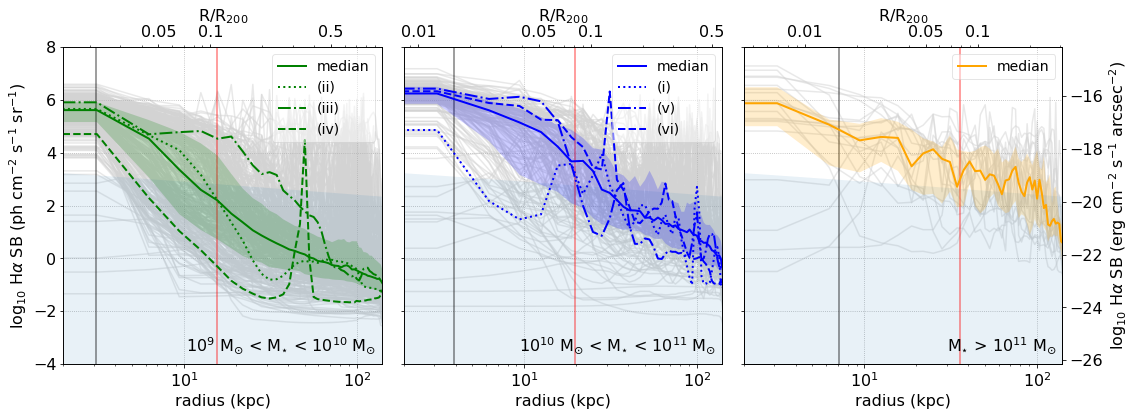

In [20]:
linewidth=2
fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(16,6))
ax1.grid(linestyle=':')
median_9to10,p25_9to10,p75_9to10=Halphaprofileplot(data,xgal_9to10_all,ygal_9to10_all,boxsize,ax1=ax1,\
                                                      color='green',label='median',linewidth=linewidth)
title = r'10$^9$ M$_{\odot}$ < M$_{\star}$ < 10$^{10}$ M$_{\odot}$'
plotindividualprofiles(data,xgal_9andup,ygal_9andup,boxsize,ax1=ax1,only9=True,linewidth=linewidth)
ax1.legend(loc=1, framealpha=0.5)
#ax1.set_title(title)
ax1.text(130,-3.5,title,horizontalalignment='right',fontsize=16)

ax2.grid(linestyle=':')
median_10to11,p25_10to11,p75_10to11=Halphaprofileplot(data,xgal_10to11_all,ygal_10to11_all,boxsize,ax1=ax2,\
                                                         color='blue',label = 'median',linewidth=linewidth)
plotindividualprofiles(data,xgal_9andup,ygal_9andup,boxsize,ax1=ax2,only10=True,linewidth=linewidth)
title = r'10$^{10}$ M$_{\odot}$ < M$_{\star}$ < 10$^{11}$ M$_{\odot}$'
ax2.legend(loc=1, framealpha=0.5)
#ax2.set_title(title)
ax2.text(130,-3.5,title,horizontalalignment='right',fontsize=16)

ax3.grid(linestyle=':')
median_11andup,p25_11andup,p75_11andup=Halphaprofileplot(data,xgal_11andup_all,ygal_11andup_all,boxsize,ax1=ax3,\
                                                         color='orange',label = 'median',linewidth=linewidth)
#plotindividualprofiles(data,xgal_9andup,ygal_9andup,boxsize,ax1=ax3)
title = r'M$_{\star}$ > 10$^{11}$ M$_{\odot}$'
ax3.legend(loc=1, framealpha=0.5)
#ax3.set_title(title)
ax3.text(130,-3.5,title,horizontalalignment='right',fontsize=16)

ax2.set_yticklabels([])
ax2.set_ylabel('')
#ax2.set_yticks([])
ax3.set_yticklabels([])
ax3.set_ylabel('')

reff_lw = 1.5
print ('The inner CGM for the first plot is: %s'%np.median(rhstar_9to10_all))
print ('The inner CGM for the second plot is: %s'%np.median(rhstar_10to11_all))
print ('The inner CGM for the third plot is: %s'%np.median(rhstar_11andup_all))
ax1.plot([np.median(rhstar_9to10_all),np.median(rhstar_9to10_all)],[-4,8],color='black',linewidth=reff_lw,zorder=2,alpha=0.5)
ax2.plot([np.median(rhstar_10to11_all),np.median(rhstar_10to11_all)],[-4,8],color='black',linewidth=reff_lw,zorder=2,alpha=0.5)
ax3.plot([np.median(rhstar_11andup_all),np.median(rhstar_11andup_all)],[-4,8],color='black',linewidth=reff_lw,zorder=2,alpha=0.5)

ax1.plot([5*np.median(rhstar_9to10_all),5*np.median(rhstar_9to10_all)],[-4,8],color='red',linewidth=reff_lw,zorder=2,alpha=0.5)
ax2.plot([5*np.median(rhstar_10to11_all),5*np.median(rhstar_10to11_all)],[-4,8],color='red',linewidth=reff_lw,zorder=2,alpha=0.5)
ax3.plot([5*np.median(rhstar_11andup_all),5*np.median(rhstar_11andup_all)],[-4,8],color='red',linewidth=reff_lw,zorder=2,alpha=0.5)

print (5*np.median(rhstar_9to10_all))
print (5*np.median(rhstar_10to11_all))
print (5*np.median(rhstar_11andup_all))

ax5 = ax1.twiny()
ax6 = ax2.twiny()
ax7 = ax3.twiny()

loglog = True
if loglog:
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax3.set_xscale('log')
    ax5.set_xscale('log')
    ax6.set_xscale('log')
    ax7.set_xscale('log')

ax1.set_xlim(2.,140)
ax2.set_xlim(2.,140)
ax3.set_xlim(2.,140)
ax1.set_ylabel(r'log$_{10}$ H$\alpha$ SB (ph cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')

ax5.set_xlabel('R/R$_{200}$')
ax5.set_xlim(2./np.median(R200_9to10_all),140./np.median(R200_9to10_all))
if loglog:
    ax5.set_xticks([0.05,0.1,0.5])
    ax5.set_xticklabels([0.05,0.1,0.5])
print (np.median(R200_9to10_all))
print (np.median(RTopHat_9to10_all))

ax6.set_xlabel('R/R$_{200}$')
ax6.set_xlim(2./np.median(R200_10to11_all),140./np.median(R200_10to11_all))
if loglog:
    ax6.set_xticks([0.01,0.05,0.1,0.5])
    ax6.set_xticklabels([0.01,0.05,0.1,0.5])
print (np.median(R200_10to11_all))
print (np.median(RTopHat_10to11_all))

ax7.set_xlabel('R/R$_{200}$')
ax7.set_xlim(2./np.median(R200_11andup_all),140./np.median(R200_11andup_all))
if loglog:
    ax7.set_xticks([0.01,0.05,0.1])
    ax7.set_xticklabels([0.01,0.05,0.1])
print (np.median(R200_11andup_all))
print (np.median(RTopHat_11andup_all))

if loglog:
    for ax in [ax1,ax2,ax3]:
        ax.set_xlabel(r'radius (kpc)')
    for ax in [ax5,ax6,ax7]:
        ax.set_xlabel(r'R/R$_{200}$')
        
#SB_cgs = 10**-22 *u.erg / u.arcsec**2 / u.cm**2 / u.s
def getSB_ph(SB_cgs,photon_wavelength=656.3e-9*u.m):
    return SB_cgs * photon_wavelength/(const.h.to('erg s') * const.c.to('m/s')) * (206265.*u.arcsec)**2/u.sr
def getSB_cgs(SB_ph,photon_wavelength=656.3e-9*u.m):
    return SB_ph / (photon_wavelength/(const.h.to('erg s') * const.c.to('m/s')) * (206265.*u.arcsec)**2/u.sr)
print (getSB_ph(10**-19 *u.erg / u.arcsec**2 / u.cm**2 / u.s))

ax8 = ax3.twinx()
ax8.set_ylabel(r'log$_{10}$ H$\alpha$ SB (erg cm$^{-2}$ s$^{-1}$ arcsec$^{-2}$)')
ax8.set_ylim(np.log10(getSB_cgs(10**-4).value),np.log10(getSB_cgs(10**8).value))
print (getSB_cgs(10**-4),getSB_cgs(10**8))

# Read in the surface brightness limits from a text file: They were calculated in SignalToNoise_azimuthalaveraging_limits
#ff = open('../SignalToNoise_azimuthalaveraging_limits_sigma1_5.txt','r')
ff = open('../SignalToNoise_azimuthalaveraging_limits_sigma3.txt','r')
readradius = []
readSB = []
for line in ff:
    if line[0]!='#'and len(line)>5:
        tmp = line.split()
        readradius.append(tmp[0])
        readSB.append(tmp[1])
ff.close()
readradius = np.array(readradius,'d')
readSB = np.array(readSB,'d')

#ax1.plot(readradius,np.log10(readSB),'k--',alpha=0.5)
#ax2.plot(readradius,np.log10(readSB),'k--',alpha=0.5)
#ax3.plot(readradius,np.log10(readSB),'k--',alpha=0.5)

ax1.fill_between(readradius,np.log10(readSB),y2 = -4,alpha=0.1,zorder = 2)
ax2.fill_between(readradius,np.log10(readSB),y2 = -4,alpha=0.1,zorder = 2)
ax3.fill_between(readradius,np.log10(readSB),y2 = -4,alpha=0.1,zorder = 2)

fig.subplots_adjust( wspace = 0, top=.95)
plt.tight_layout()

if loglog:
    printlog = '_log'
else:
    printlog = ''
# plt.savefig('extract_FOV_and_cutout_galaxies_halphaprofiles_selectingbetweenmass_v4%s_3sigmalim.png'%printlog)

## Zhang et al 2016: SDSS sightlines through the local CGM --> H$\alpha$ emission 

<img src="zhang2016_hanii.jpg">